In [1]:
%load_ext autoreload
%autoreload 2
import time, os
#os.environ["TZ"] = "US/Eastern"
time.tzset() 
from rnn_lstm_attention_captioning import *
from helper import *
#hello()

#py_path = os.path.join(GOOGLE_DRIVE_PATH, 'rnn_lstm_attention_captioning.py')
#py_edit_time = time.ctime(os.path.getmtime(py_path))
#print('rnn_lstm_attention_captioning.py last edited on %s' % py_edit_time)

In [3]:

import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F

from backend.utils import reset_seed, tensor_to_image, decode_captions, attention_visualizer
from backend.grad import rel_error, compute_numeric_gradient
import matplotlib.pyplot as plt
import time

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
if torch.cuda.is_available:
    print('Good to go!')

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go!


# Microsoft COCO
We will use the 2014 release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.
Our subset contains 10,000 image-caption pairs for training and 500 for testing. The images have been downsampled to 112x112 for computation efficiency and captions are tokenized and numericalized, clamped to 15 words.

In [6]:

if os.path.isfile('./datasets/coco.pt'):
    print('COCO data exist')
else:
    print('downloading COCO dataset')
    !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt -P ./datasets/

# load COCO data from coco.pt, loaf_COCO is implemented in helper.py
data_dict = load_COCO(path = './datasets/coco.pt')

num_train = data_dict['train_images'].size(0)
num_val = data_dict['val_images'].size(0)

# declare variables for special tokens
NULL_index = data_dict['vocab']['token_to_idx']['<NULL>']
START_index = data_dict['vocab']['token_to_idx']['<START>']
END_index = data_dict['vocab']['token_to_idx']['<END>']
UNK_index = data_dict['vocab']['token_to_idx']['<UNK>']


COCO data exist
train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])

Train images shape:  torch.Size([10000, 3, 112, 112])
Train caption tokens shape:  torch.Size([10000, 17])
Validation images shape:  torch.Size([500, 3, 112, 112])
Validation caption tokens shape:  torch.Size([500, 17])
total number of caption tokens:  864


## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function.

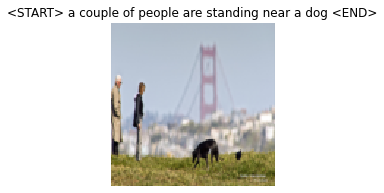

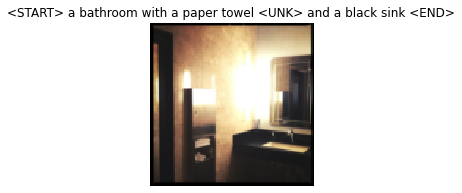

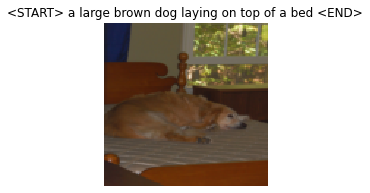

In [15]:
# Sample a minibatch and show the reshaped 112x112 images and captions
batch_size = 3

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  fig = plt.figure(figsize=(3,3))

  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  plt.title(caption_str)
  plt.show()

# Recurrent Neural Networks
As discussed in lecture, we will use Recurrent Neural Network (RNN) language models for image captioning. We will cover the vanilla RNN model first and later LSTM and attention-based language models.

## Vanilla RNN: step forward
implementing the `rnn_step_forward` for a single timestep of a vanilla recurrent neural network. Running the following to check implementation. 

In [16]:
N, D, H = 3, 10, 4

x = torch.linspace(-0.4, 0.7, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.2, 0.5, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.1, 0.9, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.3, 0.7, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.2, 0.4, steps=H, **to_double_cuda)

# YOUR_TURN: Impelement rnn_step_forward 
next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = torch.tensor([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  2.3200594408551194e-09


## Vanilla RNN: step backward: Gradient check
Implementing the `rnn_step_backward` for a single timestep of a vanilla recurrent neural network. Running the following to numerically gradient Checking. expecting error <= `1e-8`

In [17]:
reset_seed(0)
N, D, H = 4, 5, 6
x = torch.randn(N, D, **to_double_cuda)
h = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = torch.randn(*out.shape, **to_double_cuda)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dnext_h)
dprev_h_num = compute_numeric_gradient(fh, h, dnext_h)
dWx_num = compute_numeric_gradient(fWx, Wx, dnext_h)
dWh_num = compute_numeric_gradient(fWh, Wh, dnext_h)
db_num = compute_numeric_gradient(fb, b, dnext_h)

# YOUR_TURN: Impelement rnn_step_backward
dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  3.530076340711781e-10
dprev_h error:  1.023333169118312e-09
dWx error:  1.635986317441122e-10
dWh error:  3.862381098421698e-10
db error:  1.2566134268642678e-10


## Vanilla RNN: forward : For an entire sequence
Implementing `rnn_forward` by making calls to the `rnn_step_forward` function that we just defined. This help us to process an entire sequence of data


In [18]:
N, T, D, H = 2, 3, 4, 5

x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
h0 = torch.linspace(-0.3, 0.1, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.2, 0.4, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.4, 0.1, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.7, 0.1, steps=H, **to_double_cuda)


h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = torch.tensor([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]], **to_double_cuda)
print('h error: ', rel_error(expected_h, h))

h error:  4.242275290213816e-09


## Vanilla RNN: backward for an entire sequence of data
Implementing the `rnn_backward` for a vanilla RNN. This runs back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that we defined earlier.


In [19]:
reset_seed(0)

N, D, T, H = 2, 3, 10, 5

x = torch.randn(N, T, D, **to_double_cuda)
h0 = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
dh0_num = compute_numeric_gradient(fh0, h0, dout)
dWx_num = compute_numeric_gradient(fWx, Wx, dout)
dWh_num = compute_numeric_gradient(fWh, Wh, dout)
db_num = compute_numeric_gradient(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  5.815642230504831e-10
dh0 error:  7.125196140592365e-10
dWx error:  8.020741839108524e-10
dWh error:  1.1608144889788916e-09
db error:  1.2083739927736994e-09


## Vanilla RNN: backward with autograd

In [20]:
reset_seed(0)

N, D, T, H = 2, 3, 10, 5

# set requires_grad=True
x = torch.randn(N, T, D, **to_double_cuda, requires_grad=True)
h0 = torch.randn(N, H, **to_double_cuda, requires_grad=True)
Wx = torch.randn(D, H, **to_double_cuda, requires_grad=True)
Wh = torch.randn(H, H, **to_double_cuda, requires_grad=True)
b = torch.randn(H, **to_double_cuda, requires_grad=True)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

# manual backward
with torch.no_grad():
  dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

# backward with autograd
out.backward(dout) # the magic happens here!
dx_auto, dh0_auto, dWx_auto, dWh_auto, db_auto = \
  x.grad, h0.grad, Wx.grad, Wh.grad, b.grad

print('dx error: ', rel_error(dx_auto, dx))
print('dh0 error: ', rel_error(dh0_auto, dh0))
print('dWx error: ', rel_error(dWx_auto, dWx))
print('dWh error: ', rel_error(dWh_auto, dWh))
print('db error: ', rel_error(db_auto, db))

dx error:  1.940674388170321e-16
dh0 error:  2.2836060460754644e-17
dWx error:  3.1057613445099113e-17
dWh error:  8.260278707379766e-17
db error:  1.3268315583600828e-16


## Image Feature Extraction
Here, we use [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) for image feature extraction. 

In [7]:
# model = FeatureExtractor(pooling=True, verbose=True, device='cuda')

## Word embedding check


In [21]:
N, T, V, D = 2, 4, 5, 3

x = torch.tensor([[0, 3, 1, 2], [2, 1, 0, 3]], **to_long_cuda)
W = torch.linspace(0, 1, steps=V*D, **to_double_cuda).reshape(V, D)

# YOUR_TURN: Impelement WordEmbedding
model_emb = WordEmbedding(V, D, **to_double_cuda)
model_emb.W_embed.data.copy_(W)
out = model_emb(x)
expected_out = torch.tensor([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]], **to_double_cuda)

print('out error: ', rel_error(expected_out, out))

out error:  2.727272753724473e-09


## (Temporal) Affine layer


In [22]:
reset_seed(0)

N, T, D, M = 2, 3, 4, 3

w = torch.linspace(-0.2, 0.4, steps=D*M, **to_double_cuda).reshape(D, M).permute(1, 0)
b = torch.linspace(-0.4, 0.1, steps=M, **to_double_cuda)

temporal_affine = nn.Linear(D, M).to(**to_double_cuda)
temporal_affine.weight.data.copy_(w)
temporal_affine.bias.data.copy_(b)

# For regular affine layer
x = torch.linspace(-0.1, 0.3, steps=N*D, **to_double_cuda).reshape(N, D)
out = temporal_affine(x)
print('affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[-0.35584416, -0.10896104,  0.13792208],
                     [-0.31428571, -0.01753247,  0.27922078]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))

x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
out = temporal_affine(x)
print('\ntemporal affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[[-0.39920949, -0.16533597,  0.06853755],
                             [-0.38656126, -0.13750988,  0.11154150],
                             [-0.37391304, -0.10968379,  0.15454545]],
                            [[-0.36126482, -0.08185771,  0.19754941],
                             [-0.34861660, -0.05403162,  0.24055336],
                             [-0.33596838, -0.02620553,  0.28355731]]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))

affine layer - input shape: torch.Size([2, 4]), output shape: torch.Size([2, 3])
dx error:  6.021897849884195e-09

temporal affine layer - input shape: torch.Size([2, 3, 4]), output shape: torch.Size([2, 3, 3])
dx error:  6.039603964764421e-09


## Temporal Softmax loss


In [29]:
def check_loss(N, T, V, p):
    x = 0.001 * torch.randn(N, T, V, **to_double_cuda)
    y = torch.randint(V, size=(N, T), **to_long_cuda)
    mask = torch.rand(N, T, **to_double_cuda)
    y[mask > p] = 0
    # YOUR_TURN: Impelement temporal_softmax_loss
    print(temporal_softmax_loss(x, y, NULL_index).item())
  
check_loss(1000, 1, 10, 1.0)   
check_loss(1000, 10, 10, 1.0)  
check_loss(5000, 10, 10, 0.1) 

2.0815791002459574
20.7693693974595
2.108242866159342


## Captioning Module


In [23]:
reset_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

# YOUR_TURN: Impelement CaptioningRNN
model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          ignore_index=NULL_index,
          **to_float_cuda) # use float here to be consistent with MobileNet v2


for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 150.6090393066

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  150.60903930664062
expected loss:  150.6090393066
difference:  0.0


## Image Captioning solver


In [24]:
def captioning_train(rnn_model, image_data, caption_data, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnn_model.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(image_data.shape[0] // batch_size)
  loss_history = []
  rnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      images, captions = image_data[j*batch_size:(j+1)*batch_size], \
                           caption_data[j*batch_size:(j+1)*batch_size]

      loss = rnn_model(images, captions)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()
  return rnn_model, loss_history

## Overfit small data


learning rate is:  0.001
(Epoch 0 / 80) loss: 75.2017 time per epoch: 0.0s
(Epoch 1 / 80) loss: 69.8566 time per epoch: 0.0s
(Epoch 2 / 80) loss: 64.0523 time per epoch: 0.0s
(Epoch 3 / 80) loss: 58.8465 time per epoch: 0.0s
(Epoch 4 / 80) loss: 54.0642 time per epoch: 0.0s
(Epoch 5 / 80) loss: 49.9767 time per epoch: 0.0s
(Epoch 6 / 80) loss: 46.8107 time per epoch: 0.0s
(Epoch 7 / 80) loss: 44.5066 time per epoch: 0.0s
(Epoch 8 / 80) loss: 42.8952 time per epoch: 0.0s
(Epoch 9 / 80) loss: 41.7018 time per epoch: 0.0s
(Epoch 10 / 80) loss: 40.6763 time per epoch: 0.0s
(Epoch 11 / 80) loss: 39.7282 time per epoch: 0.0s
(Epoch 12 / 80) loss: 38.8573 time per epoch: 0.0s
(Epoch 13 / 80) loss: 38.0419 time per epoch: 0.0s
(Epoch 14 / 80) loss: 37.2672 time per epoch: 0.0s
(Epoch 15 / 80) loss: 36.5864 time per epoch: 0.0s
(Epoch 16 / 80) loss: 35.9831 time per epoch: 0.0s
(Epoch 17 / 80) loss: 35.5844 time per epoch: 0.0s
(Epoch 18 / 80) loss: 35.2549 time per epoch: 0.0s
(Epoch 19 / 80) 

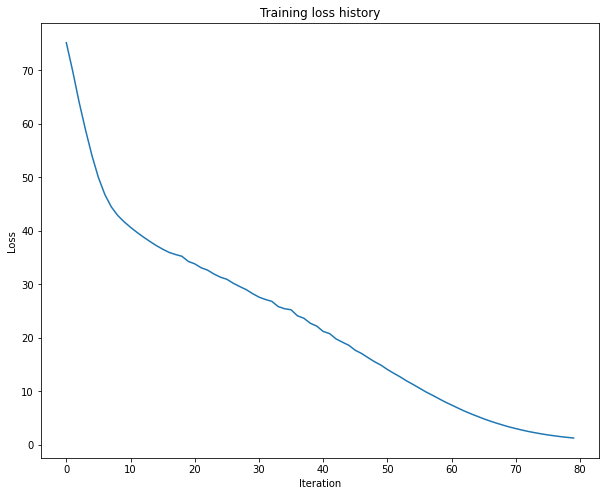

In [25]:
reset_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50
  
# create the image captioning model
model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  rnn_overfit, _ = captioning_train(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling


### Train the net


learning rate is:  0.001
(Epoch 0 / 60) loss: 47.7771 time per epoch: 5.4s
(Epoch 1 / 60) loss: 41.8434 time per epoch: 5.4s
(Epoch 2 / 60) loss: 38.9488 time per epoch: 5.6s
(Epoch 3 / 60) loss: 36.9069 time per epoch: 5.4s
(Epoch 4 / 60) loss: 35.0230 time per epoch: 5.3s
(Epoch 5 / 60) loss: 33.1912 time per epoch: 5.2s
(Epoch 6 / 60) loss: 31.4348 time per epoch: 5.5s
(Epoch 7 / 60) loss: 29.8891 time per epoch: 5.4s
(Epoch 8 / 60) loss: 28.5463 time per epoch: 5.2s
(Epoch 9 / 60) loss: 27.0739 time per epoch: 5.2s
(Epoch 10 / 60) loss: 25.6154 time per epoch: 5.2s
(Epoch 11 / 60) loss: 24.3473 time per epoch: 5.2s
(Epoch 12 / 60) loss: 23.1660 time per epoch: 5.2s
(Epoch 13 / 60) loss: 22.1758 time per epoch: 5.2s
(Epoch 14 / 60) loss: 21.1889 time per epoch: 5.2s
(Epoch 15 / 60) loss: 20.1904 time per epoch: 5.2s
(Epoch 16 / 60) loss: 19.2067 time per epoch: 5.2s
(Epoch 17 / 60) loss: 18.1735 time per epoch: 5.2s
(Epoch 18 / 60) loss: 17.5455 time per epoch: 5.6s
(Epoch 19 / 60) 

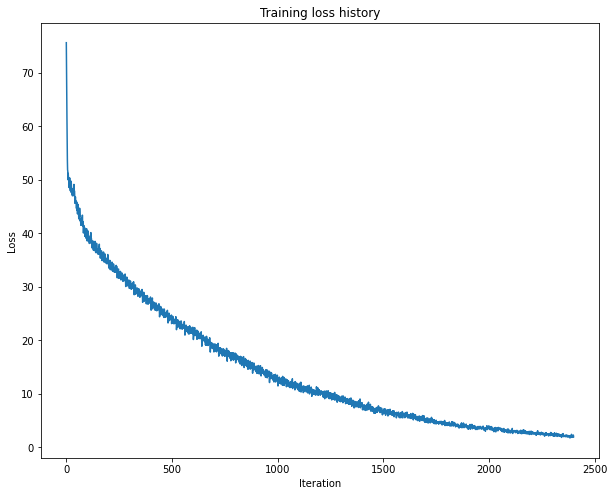

In [26]:
reset_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  rnn_model_submit, rnn_loss_submit = captioning_train(rnn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling


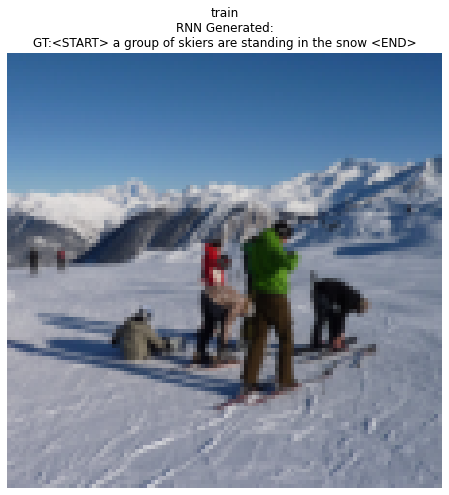

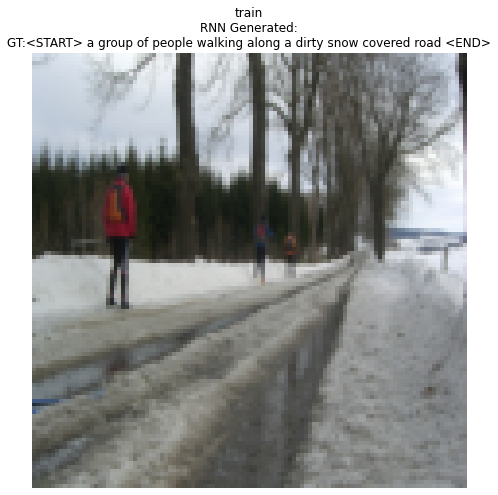

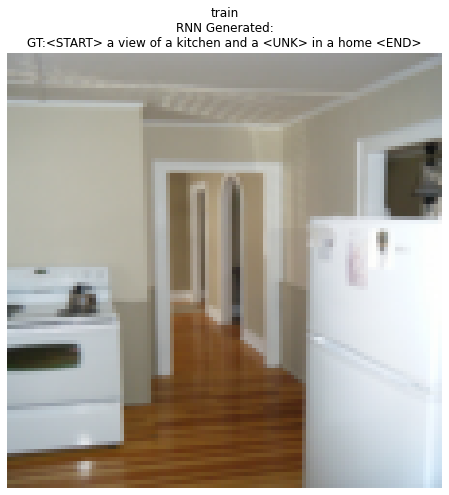

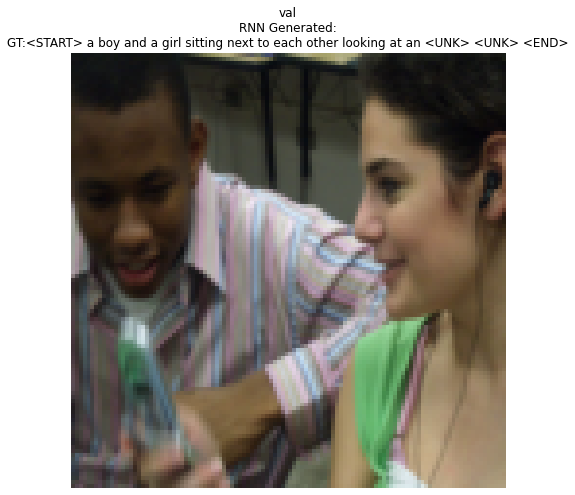

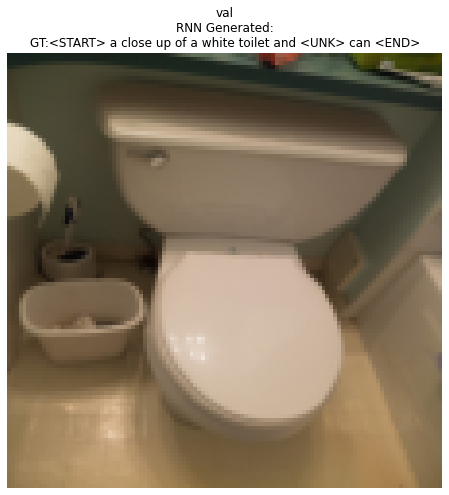

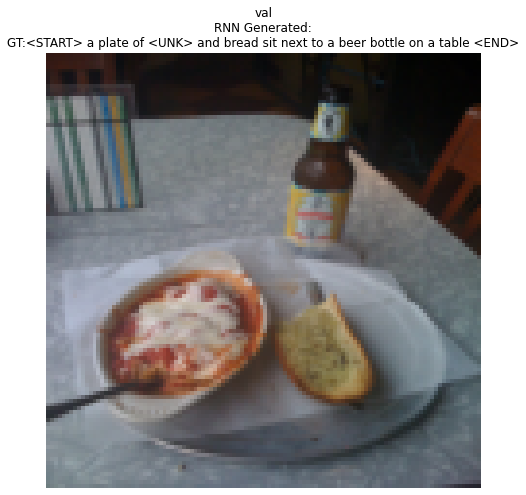

In [27]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  # decode_captions is loaded from helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  rnn_model.eval()
  generated_captions = rnn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nRNN Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

# Image Captioning with LSTMs


## LSTM: step forward 

In [28]:
N, D, H = 3, 4, 5
x = torch.linspace(-0.4, 1.2, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.3, 0.7, steps=N*H, **to_double_cuda).reshape(N, H)
prev_c = torch.linspace(-0.4, 0.9, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-2.1, 1.3, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.7, 2.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.3, 0.7, steps=4*H, **to_double_cuda)

# YOUR_TURN: Impelement lstm_step_forward
next_h, next_c = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = torch.tensor([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]], **to_double_cuda)
expected_next_c = torch.tensor([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  2.606541143878583e-09
next_c error:  1.7376745523804369e-09


## LSTM: forward


In [29]:
N, D, H, T = 2, 5, 4, 3
x = torch.linspace(-0.4, 0.6, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
h0 = torch.linspace(-0.4, 0.8, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.2, 0.9, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.3, 0.6, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.2, 0.7, steps=4*H, **to_double_cuda)

# YOUR_TURN: Impelement lstm_forward
h = lstm_forward(x, h0, Wx, Wh, b)

expected_h = torch.tensor([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]], **to_double_cuda)

print('h error: ', rel_error(expected_h, h))

h error:  2.668523515654886e-09


## LSTM Module

We can now wrap the LSTM functions we wrote into an nn.Module. You can check the `LSTM` module in the script.

## LSTM captioning model



In [30]:
reset_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          ignore_index=NULL_index,
          **to_float_cuda)

for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 146.3161468505

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  146.316162109375
expected loss:  146.3161468505
difference:  5.214321112077035e-08


## Overfit small data


learning rate is:  0.01
(Epoch 0 / 80) loss: 74.9039 time per epoch: 0.0s
(Epoch 1 / 80) loss: 72.2296 time per epoch: 0.0s
(Epoch 2 / 80) loss: 51.2480 time per epoch: 0.0s
(Epoch 3 / 80) loss: 47.5485 time per epoch: 0.0s
(Epoch 4 / 80) loss: 49.6912 time per epoch: 0.0s
(Epoch 5 / 80) loss: 45.3551 time per epoch: 0.0s
(Epoch 6 / 80) loss: 43.7383 time per epoch: 0.0s
(Epoch 7 / 80) loss: 42.2004 time per epoch: 0.0s
(Epoch 8 / 80) loss: 41.1369 time per epoch: 0.0s
(Epoch 9 / 80) loss: 39.7591 time per epoch: 0.0s
(Epoch 10 / 80) loss: 37.9963 time per epoch: 0.0s
(Epoch 11 / 80) loss: 36.1083 time per epoch: 0.0s
(Epoch 12 / 80) loss: 34.2351 time per epoch: 0.0s
(Epoch 13 / 80) loss: 32.5251 time per epoch: 0.0s
(Epoch 14 / 80) loss: 30.7406 time per epoch: 0.0s
(Epoch 15 / 80) loss: 29.5703 time per epoch: 0.0s
(Epoch 16 / 80) loss: 28.9203 time per epoch: 0.0s
(Epoch 17 / 80) loss: 25.7418 time per epoch: 0.0s
(Epoch 18 / 80) loss: 24.4961 time per epoch: 0.0s
(Epoch 19 / 80) l

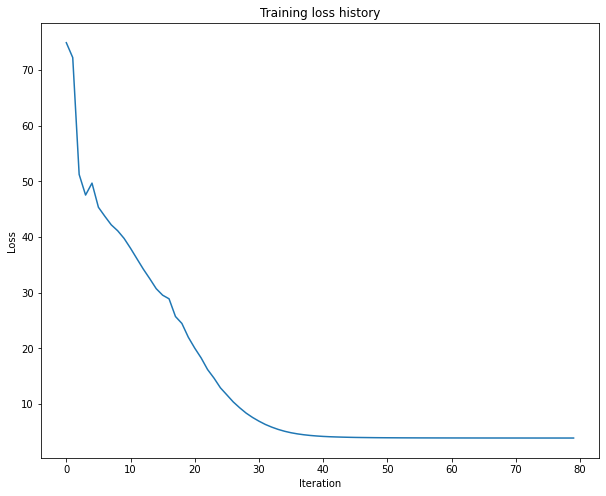

In [31]:
reset_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-2]:
  print('learning rate is: ', learning_rate)
  lstm_overfit, _ = captioning_train(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling


### Train the net
Now, perform the training on the entire training set. You should see a final loss less than `2.8`. Each epoch should take ~7s to run.

learning rate is:  0.001
(Epoch 0 / 60) loss: 49.4025 time per epoch: 5.5s
(Epoch 1 / 60) loss: 44.0543 time per epoch: 5.4s
(Epoch 2 / 60) loss: 40.2110 time per epoch: 5.4s
(Epoch 3 / 60) loss: 38.3166 time per epoch: 5.4s
(Epoch 4 / 60) loss: 36.7395 time per epoch: 5.4s
(Epoch 5 / 60) loss: 35.1847 time per epoch: 5.4s
(Epoch 6 / 60) loss: 33.7785 time per epoch: 5.4s
(Epoch 7 / 60) loss: 32.4943 time per epoch: 5.4s
(Epoch 8 / 60) loss: 31.3009 time per epoch: 5.4s
(Epoch 9 / 60) loss: 30.1774 time per epoch: 5.4s
(Epoch 10 / 60) loss: 29.1189 time per epoch: 5.4s
(Epoch 11 / 60) loss: 28.1340 time per epoch: 5.4s
(Epoch 12 / 60) loss: 27.2132 time per epoch: 5.4s
(Epoch 13 / 60) loss: 26.3524 time per epoch: 5.4s
(Epoch 14 / 60) loss: 25.3534 time per epoch: 5.4s
(Epoch 15 / 60) loss: 24.3034 time per epoch: 5.4s
(Epoch 16 / 60) loss: 23.2611 time per epoch: 5.4s
(Epoch 17 / 60) loss: 22.4366 time per epoch: 5.4s
(Epoch 18 / 60) loss: 21.4085 time per epoch: 5.4s
(Epoch 19 / 60) 

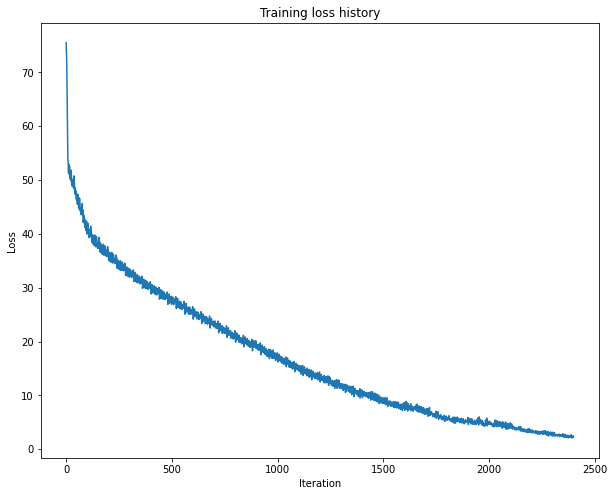

In [ ]:
reset_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  lstm_model_submit, lstm_loss_submit = captioning_train(lstm_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling
As with the RNN, the samples on training data should be very good; the samples on validation data will probably make less sense.

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  # decode_captions is loaded from helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  lstm_model.eval()
  generated_captions = lstm_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nLSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()